<a href="https://colab.research.google.com/github/vitroid/TileCycles/blob/main/TileCycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install genice to generate the structure of ice.
! pip install genice2

     |████████████████████████████████| 696kB 5.5MB/s 
  Created wheel for genice2: filename=GenIce2-2.1b3-py2.py3-none-any.whl size=836944 sha256=f783af608bb2be10b19724097893170adec6dd4e57fa94d9897511b25c3f939c
  Stored in directory: /root/.cache/pip/wheels/b2/c4/db/0ae48f964fbb8179e85be5292912d1a491f8f35f5560d1d1a5
  Created wheel for pairlist: filename=PairList-0.2.11.1-cp37-cp37m-linux_x86_64.whl size=35272 sha256=721d813ae4f22138d5f8c92f6403dd1f8adbcdd7af61790ea39e93853c1a7432
  Stored in directory: /root/.cache/pip/wheels/74/20/2f/64c940bb1f1046f7859faad73d7ea02597b5f224153795e2d1
  Created wheel for methodtools: filename=methodtools-0.4.2-cp37-none-any.whl size=2986 sha256=979da1ec92e8ce367433b3046ce187d1107ad8647b43f9597c5d7fd64d9e5132
  Stored in directory: /root/.cache/pip/wheels/94/6a/63/a364e72d0abc8869f68b3fd19d701b428b9a0d2579d06f78ae
  Created wheel for wirerope: filename=wirerope-0.4.2-cp37-none-any.whl size=8749 sha256=8a98fe70c8935fa3f216009f5bf12eff16fb2a15dbdaae969e

## benchmark test

In [2]:
from genice2.genice import GenIce
from genice2.plugin import Lattice, Format, Molecule

import networkx as nx
import numpy as np
import random
import time


# sampling parameters for benchmarking
# Accurate
maxRepeat = 100  # loops
maxAccum  = 25   # sec
maxProc   = 100  # sec
maxNode   = 1000000

# Rough estimate
# maxRepeat = 10  # loops
# maxAccum  = 5   # sec
# maxProc   = 10  # sec
# maxNode   = 100000

In [3]:
def test_icerule(d, N):
    assert d.number_of_nodes() == N
    for node in d:
        assert d.in_degree(node) == 2
        assert d.in_degree(node) == 2        

## Buch's algorithm

There are two hydrogen sites between two neighboring oxygens, and Buch's algorithm assumes that the initial configuration is one in which all the hydrogens randomly occupy one of the two sites.

In the initial configuration, there are many oxygen atoms with excess hydrogen. The algorithm migrates hydrogen from such an oxygen atom to a neighboring oxygen atom, and repeats the process randomly until there are two hydrogen species in every oxygen atom.


In [4]:
def migrate(d, excess):
    """
    excess is a set of nodes having more than two outgoing edges
    """
    while len(excess) > 0:
        # random choice from candidates;
        # there may be faster ways
        head = random.choice(list(excess))
        nexts = list(d.successors(head))
        next = random.choice(nexts)
        d.remove_edge(head, next)
        d.add_edge(next, head)
        # if head's outgoing order was three
        if len(nexts) == 3:
            # remove from the excess list
            excess.remove(head)
        # if next's outgoing orderis three
        if d.out_degree(next) == 3:
            # it becomes a new excess
            excess.add(next)


lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph
water = Molecule("spce")

buch = []
lastN = 0
for NN in range(8, 100):
    N = int(1.4**(NN/3))
    if N == lastN:
        continue
    lastN = N
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
    g = raw['graph']
    Nnode = g.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        dd = nx.DiGraph()
        for a, b in g.edges():
            if random.randint(0, 1) == 1:
                dd.add_edge(a, b)
            else:
                dd.add_edge(b, a)

        now = time.time()
        migrate(dd, set([x for x in dd.nodes if dd.out_degree(x) > 2]))
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    buch.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if delta > maxProc:
        break
    if Nnode > maxNode:
        break

64 molecules 0.0009599018096923828 s avg. 100 reps.
216 molecules 0.0036502838134765624 s avg. 100 reps.
512 molecules 0.010582818984985351 s avg. 100 reps.
1000 molecules 0.0255122971534729 s avg. 100 reps.
1728 molecules 0.051926758289337155 s avg. 100 reps.
2744 molecules 0.09509040594100952 s avg. 100 reps.
4096 molecules 0.17122009992599488 s avg. 100 reps.
5832 molecules 0.27808052433861624 s avg. 90 reps.
8000 molecules 0.4515446594783238 s avg. 56 reps.
10648 molecules 0.8088009511270831 s avg. 31 reps.
17576 molecules 2.3172121914950283 s avg. 11 reps.
21952 molecules 3.5371090471744537 s avg. 8 reps.
32768 molecules 7.8803165555000305 s avg. 4 reps.
46656 molecules 15.422428131103516 s avg. 2 reps.
64000 molecules 31.83476972579956 s avg. 1 reps.
97336 molecules 69.93647599220276 s avg. 1 reps.
125000 molecules 120.56298804283142 s avg. 1 reps.


## GenIce algorithm

Tiling by cycles.

In [5]:
from collections import defaultdict


def find_cycle(g, chain, order):
    # head of the snake
    head = chain[-1]
    # neck is the vertex next to head
    neck = -1
    if len(chain) > 1:
        neck = chain[-2]
    while True:
        # candidates for the next step
        candids = [i for i in g[head] if i != neck]
        # go ahead
        neck = head
        head = random.choice(candids)
        # lookup the new head in the markers
        i = order[head]
        # if it is marked as the tail end of the snake,
        if i == 0:
            # the random walk returns to the first node of the chain;
            # unmark the head.
            order[head] = -1
            # return an empty chain and a cycle
            return [], chain
        # if the random walk crosses at an intermediate node of the chain,
        elif i > 0:
            # return a chain and a cycle
            return chain[:i+1], chain[i:]
        # otherwise, mark the new head position
        order[head] = len(chain)
        chain.append(head)


def remove_cycle(g, cycle, order):
    # unmark vertices in the cycle (except for the first vertecx)
    for i in range(1, len(cycle)):
        order[cycle[i]] = -1
    # remove edges of the cycle
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        g.remove_edge(a, b)
    # remove edgeless vertices in the graph
    for a in cycle:
        if g.degree(a) == 0:
            g.remove_node(a)


def tileByCycles(g):
    # random walk path
    chain = []
    # markers that indicate the orders in the path
    order = -np.ones(g.number_of_nodes(), dtype=np.int)
    while g.number_of_nodes() > 0:
        # if the chain is empty
        if len(chain) == 0:
            # randomly select the "head" node.
            head = random.choice(list(g.nodes()))
            chain = [head]
            # mark it as the first node.
            order[head] = 0
        # walk randomly to find a cycle.
        chain, cycle = find_cycle(g, chain, order)
        # found.
        yield cycle
        # remove it from the graph and unmark.
        remove_cycle(g, cycle, order)


lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph
water = Molecule("spce")

gen = []
for NN in range(4, 100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
    g0 = raw['graph']
    Nnode = g0.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        g = nx.Graph(g0)

        now = time.time()
        dd = nx.DiGraph()
        for cycle in tileByCycles(g):
            nx.add_cycle(dd, cycle)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    gen.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if Nnode >= maxNode:
        break

64 molecules 0.001320033073425293 s avg. 100 reps.
216 molecules 0.0016901969909667968 s avg. 100 reps.
512 molecules 0.004071691036224365 s avg. 100 reps.
1000 molecules 0.008070731163024902 s avg. 100 reps.
1728 molecules 0.014325029850006103 s avg. 100 reps.
4096 molecules 0.0364236855506897 s avg. 100 reps.
8000 molecules 0.07333219051361084 s avg. 100 reps.
13824 molecules 0.13124616146087648 s avg. 100 reps.
32768 molecules 0.3698941889931174 s avg. 68 reps.
64000 molecules 0.8066396713256836 s avg. 31 reps.
125000 molecules 1.7406960169474284 s avg. 15 reps.
262144 molecules 3.959371328353882 s avg. 7 reps.
512000 molecules 8.440053701400757 s avg. 3 reps.
1000000 molecules 21.166125535964966 s avg. 2 reps.


## Rahman's algorithm

The algorithm prepares a depolarized structure in advance and generates a hydrogen-disordered structure by successively reversing randomly chosen homodromic cycles.

Here, the ice Ic structure generated by GenIce is used as an initial structure, and the procedure is repeated until all the edges are inverted at least once.

In [6]:
import random


def six(d, Nnode):
    """
    find a cyclic path in the given digraph.
    d: digraph (networkx.DiGraph)
    """
    head = random.randint(0, Nnode-1)
    path = [head]
    while True:
        nexts = list(d.neighbors(head))
        next = random.choice(nexts)
        if next in path:
            i = path.index(next)
            return path[i:]
        path.append(next)
        head = next


def invertCycle(d, cycle, g):
    for i in range(len(cycle)):
        a, b = cycle[i-1], cycle[i]
        d.remove_edge(a, b)
        d.add_edge(b, a)
        # footprint
        if g.has_edge(a, b):
            g.remove_edge(a, b)


lattice = Lattice("1c")
formatter = Format("raw", stage=(3,))  # We need the directed graph of ice!
water = Molecule("spce")

rahman = []
for N in range(1, 20):
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
    d = nx.DiGraph(raw['digraph'].edges())
    Nnode = d.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        # footprint
        g = nx.Graph(d)

        now = time.time()
        while g.number_of_edges() > 0:
            cycle = six(d, d.number_of_nodes())
            invertCycle(d, cycle, g)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    rahman.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(d, Nnode)
    if delta > maxProc:
        break


8 molecules 0.0004302978515625 s avg. 100 reps.
64 molecules 0.006420538425445556 s avg. 100 reps.
216 molecules 0.035842728614807126 s avg. 100 reps.
512 molecules 0.15043798923492432 s avg. 100 reps.
1000 molecules 0.549211683480636 s avg. 46 reps.
1728 molecules 1.4913478318382711 s avg. 17 reps.
2744 molecules 2.9520905282762318 s avg. 9 reps.
4096 molecules 5.943412446975708 s avg. 5 reps.
5832 molecules 11.085352102915445 s avg. 3 reps.
8000 molecules 20.083874940872192 s avg. 2 reps.
10648 molecules 33.21415185928345 s avg. 1 reps.
13824 molecules 70.66308379173279 s avg. 1 reps.
17576 molecules 97.26869082450867 s avg. 1 reps.
21952 molecules 187.14283204078674 s avg. 1 reps.


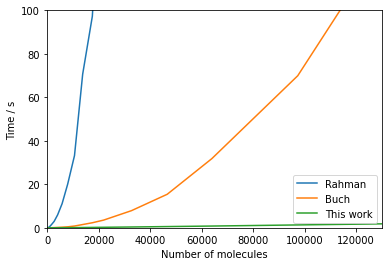

In [7]:
from matplotlib import pyplot as plt


buch = np.array(buch)
gen = np.array(gen)
rahman = np.array(rahman)


fig1, ax = plt.subplots()

# ax.set_aspect('square') #, adjustable='box')

plt.plot(rahman[:, 0], rahman[:, 1], label="Rahman")
plt.plot(buch[:, 0], buch[:, 1], label="Buch")
plt.plot(gen[:, 0], gen[:, 1], label="This work")
plt.xlim(0, 130000)
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")
plt.ylim(0, 100)
plt.show()

fig1.savefig("benchmark.pdf")

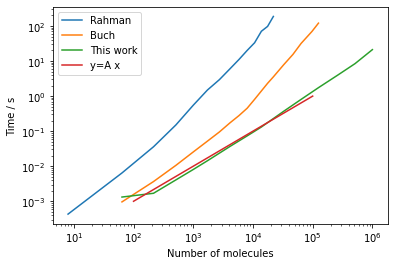

In [8]:
fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.loglog(rahman[:, 0], rahman[:, 1], label="Rahman")
plt.loglog(buch[:, 0], buch[:, 1], label="Buch")
plt.loglog(gen[:, 0], gen[:, 1], label="This work")
plt.loglog(lin, lin*1e-5, label=r"y=A x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")

fig1.savefig("benchmark-loglog.pdf")


128


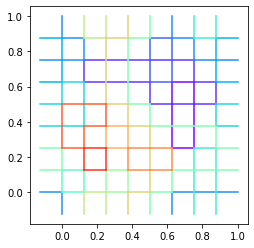

<ipython-input-9-f40769049690>:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig1.savefig("map.pdf", bbox='tight')


In [9]:
# for TOC graphics

from matplotlib import pyplot as plt


# make a 2D 6x6 ice.
def draw_cycle(cycle, pos, N, col):
    threshold = 1.1/N**2
    cm = plt.get_cmap('rainbow')
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        va = pos[a]
        vb = pos[b]
        d = vb - va
        if d@d > threshold:
            d -= np.floor(d+0.5)
            seg = np.vstack([vb-d, vb])
            plt.plot(seg[:, 0], seg[:, 1], color=cm(col))
        seg = np.vstack([va, va+d])
        plt.plot(seg[:, 0], seg[:, 1], color=cm(col))


N = 8
X = np.arange(N)
Y = np.arange(N)
X, Y = np.meshgrid(X, Y)
X = X.reshape(N * N)
Y = Y.reshape(N * N)
pos = np.vstack([X, Y]).T / N  # fractional coordinate
g = nx.Graph()
for a in range(N*N):
    for b in range(a):
        d = pos[a] - pos[b]
        d -= np.floor(d+0.5)
        if (d@d)*N*N < 1.1:
            g.add_edge(a, b)

print(g.number_of_edges())


fig1, ax = plt.subplots()

cycles = []
dd = nx.DiGraph()
for cycle in tileByCycles(g):
    cycles.append(cycle)

for i, cycle in enumerate(cycles):
    draw_cycle(cycle, pos, N, i/len(cycles))

ax.set_aspect('equal', adjustable='box')
plt.show()
fig1.savefig("map.pdf", bbox='tight')

In [14]:
!pip install tilecycles

  Created wheel for tilecycles: filename=TileCycles-0.1.3-cp37-cp37m-linux_x86_64.whl size=97017 sha256=b1270a7012b4308d528f6848dd1d40b4d5bb4683ad680da36fffe367b6b33796
  Stored in directory: /root/.cache/pip/wheels/92/b8/e1/1d9df05efa5dffd9e7e1b3650a2844e857e5fdd1dfa245cdbc
Successfully built tilecycles


In [ ]:
# C++ implementation

import tilecycles as tc
import numpy as np

lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph
water = Molecule("spce")

seed = 1111

cpp = []
for NN in range(4, 100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(water, formatter)
    g0 = raw['graph']
    Nnode = g0.number_of_nodes()

    pairs = np.array([(i, j) for i, j in g0.edges()], dtype=np.int32)

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        now = time.time()
        dd = nx.DiGraph()
        for cycle in tc.tile(pairs, Nnode, seed):
            nx.add_cycle(dd, cycle)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    cpp.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if Nnode >= maxNode:
        break

64 molecules 0.00013041257858276367 s avg. 100 reps.
216 molecules 0.00043094635009765625 s avg. 100 reps.
512 molecules 0.0010037732124328614 s avg. 100 reps.
1000 molecules 0.0019905233383178712 s avg. 100 reps.
1728 molecules 0.0033107757568359374 s avg. 100 reps.
4096 molecules 0.00972919464111328 s avg. 100 reps.
8000 molecules 0.029241757392883302 s avg. 100 reps.
13824 molecules 0.0573698902130127 s avg. 100 reps.
32768 molecules 0.15115628480911256 s avg. 100 reps.
64000 molecules 0.3217358405773456 s avg. 78 reps.
125000 molecules 0.6451614453242376 s avg. 39 reps.
262144 molecules 1.4254716767205133 s avg. 18 reps.
512000 molecules 2.9338805145687528 s avg. 9 reps.


In [ ]:
from matplotlib import pyplot as plt


gen = np.array(gen)
cpp = np.array(cpp)


fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.loglog(gen[:, 0], gen[:, 1], label="Python")
plt.loglog(cpp[:, 0], cpp[:, 1], label="C++")

plt.loglog(lin, lin*1e-5, label=r"y=A x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")

fig1.savefig("benchmark-cp-loglog.pdf")

# C++ is four times faster than python,
# but Python is fast enough...

In [18]:
!pip install pycodestyle flake8 pycodestyle_magic

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 71kB 4.3MB/s 


In [19]:
%load_ext pycodestyle_magic